**This notebook shows how machine learning techniques  can apply in Semi-conductor Industry.**

**Our Objective:** To identify different types of wafer map failure pattern automatically instead of manual work, so that the semi-conductor fabrication can improve on the yield of wafers manufacturing process.

Here, we list all reference:

[1]Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets [paper downloas link](http://ieeexplore.ieee.org/document/6932449/)

[2]Wafer Defect Patterns Recognition Based on OPTICS and Multi-Label Classification [paper download link](http://ieeexplore.ieee.org/document/7867343/)

**Step1:  Define your problem**

* **Input:** WM-811K dataset provided by *[MIR lab]*(http://mirlab.org/dataSet/public/). 

  *(For convenience, I have converted the original (dot)mat file to (dot)pkl file and you may download from this kernel.)*

* **Model:** One-VS-One multi-class SVMs. 

* **Output:** Failure pattern labels.

reference: https://cvlab.tistory.com/54?category=491498
https://www.kaggle.com/cchou1217/wm-811k-wafermap

In [1]:
#=================Presetting=====================
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import gc
from tensorflow.keras.backend import clear_session
#del model
clear_session()
gc.collect()
def CoreSelect(select):
    if select == 'GPU':
        config = ConfigProto()
        config.gpu_options.allow_growth = True
        session = InteractiveSession(config=config)
        tf.config.list_physical_devices('GPU')
    else:
        tf.config.list_physical_devices('CPU')
    return
device_lib.list_local_devices()
CoreSelect('GPU')
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import plotly.graph_objects as graph
import seaborn as sns
from plotly.subplots import make_subplots
from tensorflow.keras import layers,Input,models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense, Conv2D,Conv2DTranspose,UpSampling2D, MaxPooling2D, Flatten, Dropout,Input, AveragePooling2D,BatchNormalization,Activation,ZeroPadding2D,concatenate,Add
from tensorflow.keras.models import load_model,Sequential,Model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import cv2
from preparing import savefile,loadfile
from preparing import show_pattern_cmp,failcount_plot,failtype_plot,fail_plot,goodWafer,show100map,acc_plot
from preparing import dbscan_denoize,img_generator,autoencoder_model
from preparing import cv2_img_generator,FindingFailPattern,drop_blank,OnehotX,printx,printOnehotx
from sklearn.cluster import DBSCAN
import os

import warnings
#%matplotlib inline 
#print(os.listdir("c:/Users/user/Desktop"))
warnings.filterwarnings("ignore")
fault_mapping = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','None']
fault_dic = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'None':8}
np.set_printoptions(linewidth=110)
def savefile(name,xdata,ydata):
    np.savez_compressed('./data/%s'%name, a=xdata, b=ydata)
def loadfile(name):
    loaded = np.load('./data/%s.npz'%name)
    return loaded['a'] , loaded['b']
waferSizeX=48
waferSizeY=48
waferamount=5000
DBSCAN_ENABLE=True   #
IMAGE_GENERATOR=False #Result File: gen_fail_pattern48_48
CV_IMAGE_GENERATOR=True #Result File: cv2_fail_pattern48_48
AUTOENCODER=True    #Result File: autoencoder_fail_pattern48_48
RESIZE_ALL_WAFER=False 
REMOVE_BLANK=False
#*******Look*******
#https://ieeexplore.ieee.org/abstract/document/9606716?casa_token=Xj58acU0jEYAAAAA:i1LhzDHThCuqvU7JK4dtRfOYt8FQpLm90XlaHQbjqczFJowEodQfC4VUdnnK-bW7O-7YT1Oh
#https ://github.com/shuyu-wang/wafer_defect_classification


**Step2: Prepare your data**

* **Data Selection & Preprocessing: ** Consider what data is available, what data is missing and what data can be removed. Also, organize your selected data by formatting, cleaning and sampling from it.

Here is a simple **checklist** provided for you to understand your dataset better:

* Data summary
* Target distribution
* Missing value check
* Others

>** Data summary**

In [2]:
load_df=pd.read_pickle("c:/Users/user/Desktop/LSWMD.pkl")
#print(load_df.info())
print(load_df.head(5))

                                            waferMap  dieSize lotName  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   

   waferIndex trianTestLabel failureType  
0         1.0   [[Training]]    [[none]]  
1         2.0   [[Training]]    [[none]]  
2         3.0   [[Training]]    [[none]]  
3         4.0   [[Training]]    [[none]]  
4         5.0   [[Training]]    [[none]]  


* The dataset comprises **811,457 wafer maps**, along with additional information such as **wafer die size**, **lot name** and **wafer index**. 

* The training / test set were already split by domain experts, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

>Target distribution

    Display Row Wafer

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
[0 0 0 0 2 1 1 1 1 1

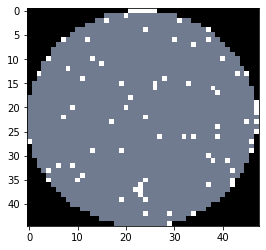

In [3]:
pd.set_option("display.max_columns",50)
np.set_printoptions(linewidth=100)
data=load_df.waferMap.iloc[9]
for i in range (len(data)):
    print(data[i])
type(data)
data.shape
#plt.xlabel("width")
plt.imshow(data,cmap=plt.cm.bone)
plt.show()

* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps ** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

        Not all lot has 25 wafers

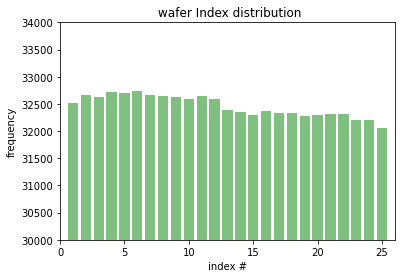

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
uni_Index=np.unique(load_df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='green', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
#plt.axhline(32000, color= 'r')
plt.show()

* The figure shows that not all lots have perfect 25 wafer maps and it may caused by **sensor failure** or other unknown problems.
* Fortunately, we do not need wafer index feature in our classification so we can just drop the variable. 

In [5]:
df = load_df.drop(['waferIndex'], axis = 1)
df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]


In [6]:
pd.set_option('display.max_colwidth',100)
print(df.loc[[0][0]])

waferMap          [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0...
dieSize                                                                                                        1683.0
lotName                                                                                                          lot1
trianTestLabel                                                                                           [[Training]]
failureType                                                                                                  [[none]]
Name: 0, dtype: object


* We can not get much information from the wafer map column but we can see the die size for each instance is different. 
* We create a new variable **'waferMapDim'** for wafer map dim checking.


In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
print("Max wafer size:",max(df.waferMapDim))
print("Min wafer size:", min(df.waferMapDim))

Max wafer size: (300, 202)
Min wafer size: (6, 21)


* The dimension of wafer map, or saying the **image size** are not always the same. We noticed that there are **632** different size for our wafer map. 
* For this reason, we must do **data tranformation** (feature extraction) to make input the same dim and the method will be introducedin the following section.

>**Missing value check**

* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [8]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
df_with_label = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_with_label =df_with_label.reset_index()
df_with_pattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_with_pattern = df_with_pattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
print("Labeled     :",df_with_label.shape[0])
print("Patterned   :", df_with_pattern.shape[0])
print("Nonpatterned:", df_nonpattern.shape[0])
print("Total wafer:",df.shape[0])

Labeled     : 172950
Patterned   : 25519
Nonpatterned: 147431
Total wafer: 811457


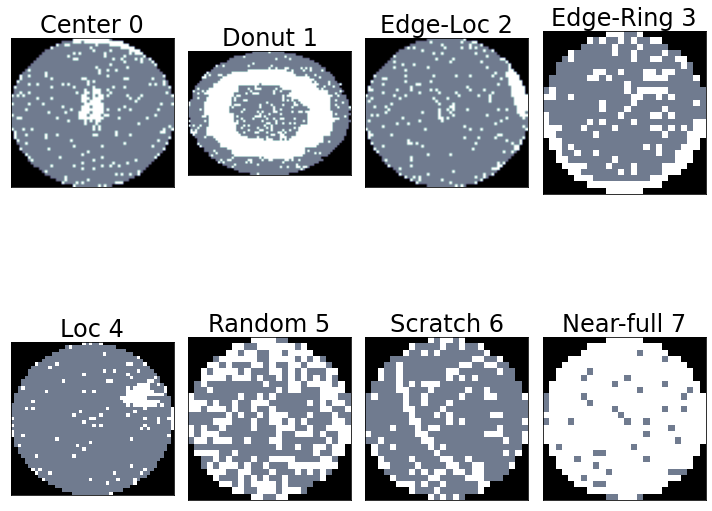

In [9]:
mapping = [9,340, 3, 16, 0, 25, 84, 37]
image=[]
each_title=[]
for i in range(8):
    image.append(df_with_pattern.waferMap[mapping[i]])
    each_title.append("%s %s"%(df_with_pattern.failureType[mapping[i]][0][0],i))
failtype_plot(image,each_title)

# Wafer size distribution

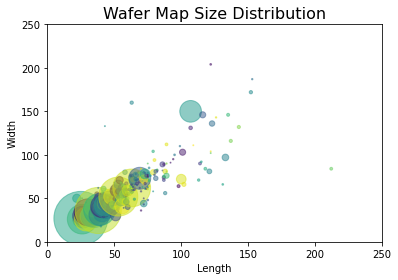

In [10]:
import matplotlib.lines as mlines
uni_Index=np.unique(df_with_pattern.waferMapDim,return_counts=True)
total=len(np.array(uni_Index[0]))
dot_size=(np.array(uni_Index[1]))
xy_loc=np.array(uni_Index[0])
x_loc,y_loc=[],[]
wafercount=0
colors=np.random.rand(total)
for i in range (total):
    x_loc.append(xy_loc[i][0])
    y_loc.append(xy_loc[i][1])
    if(xy_loc[i][0]<waferSizeX and xy_loc[i][1]<waferSizeY):
        wafercount+=1
fig, ax = plt.subplots()
ax.scatter(x_loc,y_loc,s=dot_size,alpha=0.5,c=colors)
#ax.plot([waferSizeX, waferSizeY], [0, waferSizeY],color='red') #x and y axis line value
#ax.plot([0, waferSizeY], [waferSizeX, waferSizeY],color='red')
ax.axis([0,250,0,250])
#ax.text(140,230, r'Enlarge {0:.1f}% wafer'.format((wafercount/total)*100), fontsize=12)
#ax.text(140,210, r'while re-size = %s X %s'%(waferSizeX,waferSizeY), fontsize=12)
plt.title("Wafer Map Size Distribution",fontsize=16)
plt.xlabel("Length")
plt.ylabel("Width")
plt.show()

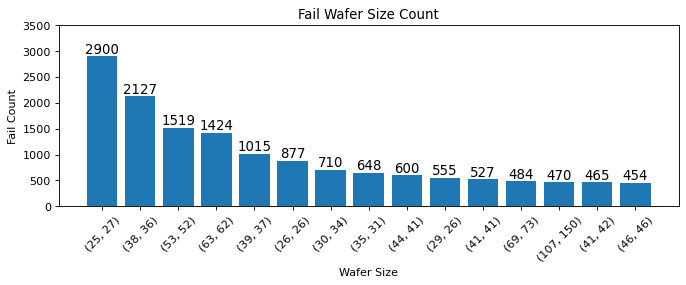

In [11]:
wafersizeshow=15
dic = { "wafersize": np.array(uni_Index[0]), "wafercount": np.array(uni_Index[1])}
a = pd.DataFrame(dic)
b=a.sort_values('wafercount',ascending=False).head(wafersizeshow)
c=b['wafercount'].to_numpy().astype('int')
d=b['wafersize'].to_numpy()
e=[]
for i in range(wafersizeshow):
    e.append(str(d[i]))
x=np.array(e)
#x= np.array([str(d[0]),str(d[1]),str(d[2]),str(d[3]),str(d[4]),str(d[5]),str(d[6]),str(d[7]),str(d[8]),str(d[9])])
y= np.array(c)

plt.figure(figsize=(10,3),dpi=80)
plt.bar(x,y,align='center',color='c',alpha=0.8)
for a,b in zip(x,y):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)
plt.bar(x,y)
plt.ylim(0,3500)
plt.xticks(rotation=45)
plt.xlabel('Wafer Size')
plt.ylabel('Fail Count')
plt.title('Fail Wafer Size Count')
plt.show()

# Fail Type with wafer size
https://www.statology.org/seaborn-stacked-bar-plot/https://www.statology.org/seaborn-stacked-bar-plot/

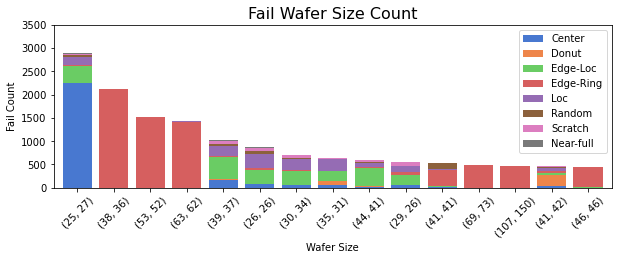

In [12]:
wafersizeshow=15
dic = { "wafersize": np.array(uni_Index[0]), "wafercount": np.array(uni_Index[1])}
a = pd.DataFrame(dic)
b=a.sort_values('wafercount',ascending=False).head(wafersizeshow)
w_count=b['wafercount'].to_numpy().astype('int')
w_shape=b['wafersize'].to_numpy()

dwp=df_with_pattern.copy()
wafersizeshow=15
list=np.zeros((wafersizeshow,8),dtype=int) # top 15 wafer size, 8 kind of fail
for i in range (wafersizeshow):
    for j in range (8):
        a=dwp.failureNum[dwp.waferMapDim==w_shape[i]]==j
        b=a.value_counts()
        try:
            #print(i,j,b[True])
            list[i][j]=b[True]
        except:
            print(end='')

draw_df = pd.DataFrame(list, index=w_shape[0:wafersizeshow], columns=fault_mapping[0:8])
my_palette = sns.color_palette("muted")
#https://pandas.pydata.org/docs/getting_started/intro_tutorials/04_plotting.html
draw_df.plot(kind='bar', stacked=True,color=my_palette,figsize=(10,3),width=0.8)
# labels for x & y axis
plt.xlabel('Wafer Size')
plt.ylabel('Fail Count')
# title of plot
plt.title('Fail Wafer Size Count',fontsize=16)
plt.ylim(0,3500)
plt.xticks(rotation=45)
plt.show()

# Fail type count

811457
172950
147431


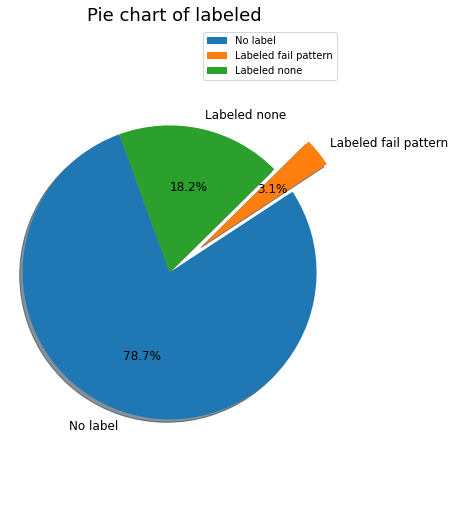

In [13]:
plt.figure(figsize=(6,9))    # 顯示圖框架大小
plt.pie([df.shape[0]-df_with_label.shape[0], df_with_pattern.shape[0], df_nonpattern.shape[0]],                           # 數值
        labels = ['No label','Labeled fail pattern','Labeled none'],                # 標籤
        autopct = "%1.1f%%",            # 將數值百分比並留到小數點一位
        explode = (0, 0.3, 0),           # 設定分隔的區塊位置
        pctdistance = 0.6,              # 數字距圓心的距離
        textprops = {"fontsize" : 12},  # 文字大小
        startangle=110,
        shadow=True)                    # 設定陰影

 
plt.axis('equal')                                          # 使圓餅圖比例相等
plt.title("Pie chart of labeled", {"fontsize" : 18})  # 設定標題及其文字大小
plt.legend(loc = "best")                                   # 設定圖例及其位置為最佳
print(df.shape[0])
print(df_with_label.shape[0])
print(df_nonpattern.shape[0])

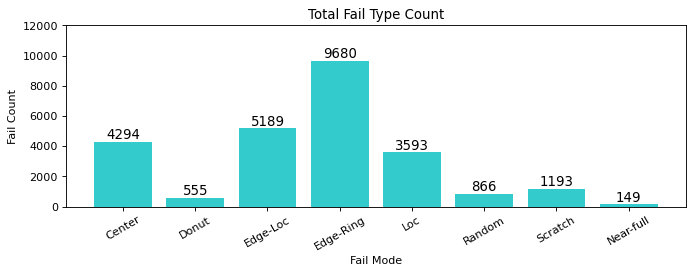

In [14]:
failcount_plot(np.array(df_with_pattern['failureNum'],dtype=int),12000,'Total Fail Type Count')

In [15]:
sub_df_with_pattern = df_with_pattern.loc[df_with_pattern['waferMapDim'] == (waferSizeX, waferSizeY)]
sub_df_with_pattern

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
23063,765010,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0...",1791.0,lot45652,[[Training]],[[Near-full]],"(48, 48)",7,0
23064,765033,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 0, 0...",1791.0,lot45653,[[Training]],[[Loc]],"(48, 48)",4,0
23065,765101,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 0, 0...",1791.0,lot45656,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23066,765139,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0...",1791.0,lot45658,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23067,765160,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0...",1791.0,lot45659,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23068,765245,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 0...",1791.0,lot45662,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23069,765246,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0...",1791.0,lot45662,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23070,765257,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0...",1791.0,lot45663,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23071,765289,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0...",1791.0,lot45664,[[Training]],[[Edge-Loc]],"(48, 48)",2,0
23072,765372,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0...",1791.0,lot45667,[[Training]],[[Edge-Loc]],"(48, 48)",2,0


# Adjusted wafer to wanted wafer size

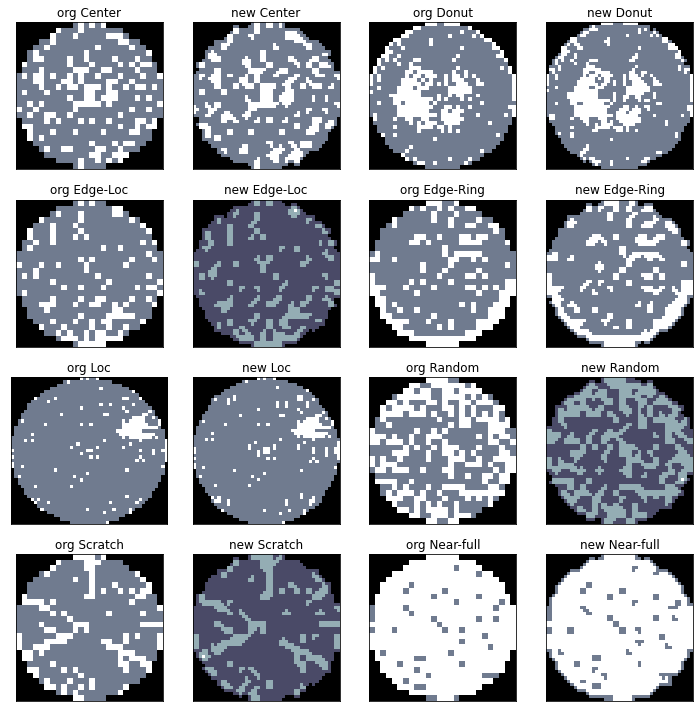

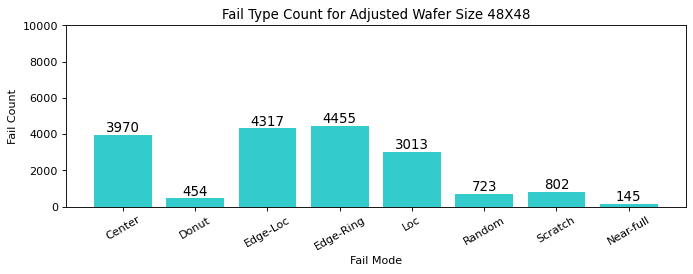

In [16]:
df_new=df_with_pattern.copy()
if RESIZE_ALL_WAFER==False:
    for i in range (df_new.shape[0]):
        if df_new.waferMapDim[i][0] > waferSizeX:
            df_new=df_new.drop(i)
        elif df_new.waferMapDim[i][1] > waferSizeY:
            df_new=df_new.drop(i)
df_new['NewWaferMap']=df_new.waferMap
for i in range (df_new.shape[0]):
    df_new.NewWaferMap.iloc[i]=cv2.resize(df_new.waferMap.iloc[i],dsize=(waferSizeX,waferSizeY),interpolation=cv2.INTER_CUBIC)
df_new = df_new.reset_index(drop=True)     

cnt = 0
fig , ax = plt.subplots(nrows = 4, ncols=4, figsize=(10,10))
ax = ax.ravel(order='C')
i,j,pic_index=0,0,0
for i in range(8):
    for j in range (df_new.shape[0]):
        if df_new.failureNum[j]==i:
            ax[pic_index].imshow(df_new.waferMap.iloc[j],cmap=plt.cm.bone)
            ax[pic_index].set_title('org %s'%(df_new.failureType[j][0][0]))
            ax[pic_index].set_xticks([])
            ax[pic_index].set_yticks([])  
            pic_index+=1
            ax[pic_index].imshow(df_new.NewWaferMap.iloc[j],cmap=plt.cm.bone)
            ax[pic_index].set_title('new %s'%(df_new.failureType[j][0][0]))
            ax[pic_index].set_xticks([])
            ax[pic_index].set_yticks([])  
            pic_index+=1 
            break
plt.tight_layout()
plt.show()
failcount_plot(np.array(df_new['failureNum'],dtype=int),10000,'Fail Type Count for Adjusted Wafer Size %sX%s'%(waferSizeX,waferSizeY))

In [17]:
#Reduce each type of samples to 3000
#Wafer Size can be fixed by setting variable fixWafer = True, 指定wafer size
#https://leemeng.tw/practical-pandas-tutorial-for-aspiring-data-scientists.html
#np.where(condition, x, y)
fixWafer=False
if fixWafer==True:
    sub_df_with_patern = df_with_pattern.loc[df_with_pattern['waferMapDim'] == (waferSizeX, waferSizeY)]
    print('Fix Wafer')
else:
    df_cal = df_new.copy()
    print('No Fix Wafer')
limit=waferamount #3000
limitCount=[0,0,0,0,0,0,0,0]
sw = np.ones((1,waferSizeX,waferSizeY))
label = []
percent=0
count=0
print(df_cal.shape[0])
for i in range(df_cal.shape[0]):
    j=df_cal.iloc[i,:]['failureNum']
    if limitCount[j]<limit:
        limitCount[j]+=1  
        if fixWafer==True:
            sw= np.concatenate((sw,df_cal.iloc[i,:]['waferMap'].reshape(1,waferSizeX,waferSizeY)))
        else:
            sw= np.concatenate((sw,df_cal.iloc[i,:]['NewWaferMap'].reshape(1,waferSizeX,waferSizeY)))
        label.append(df_cal.iloc[i,:]['failureNum'])
        #label.append(df_with_pattern.iloc[i,:]['failureType'][0][0])
        if i >count:
            percent+=1
            count=(float((df_cal.shape[0]/100)*percent))
            print('%s==>'%percent,end='')
x = sw[1:]
y = np.array(label)
print('Done')
print('x shape:%s, y shape:%s'%(x.shape,y.shape))
faulty_case=np.unique(y)
print('Faulty case list : %s'%(faulty_case))
for f in faulty_case:
      print('%s-%s : %s'%(f,fault_mapping[f],len(y[y==f])))
x=np.where(x>2,2,x)            #圖像資料大於,直接寫2
savefile('fail_pattern%s_%s'%(waferSizeX,waferSizeY),x,y)
#plt.imshow(x[0],cmap=plt.cm.bone)
#failcount_plot(y,500,'Final Type Count for %sX%s'%(waferSizeX,waferSizeY))

No Fix Wafer
17879
1==>2==>3==>4==>5==>6==>7==>8==>9==>10==>11==>12==>13==>14==>15==>16==>17==>18==>19==>20==>21==>22==>23==>24==>25==>26==>27==>28==>29==>30==>31==>32==>33==>34==>35==>36==>37==>38==>39==>40==>41==>42==>43==>44==>45==>46==>47==>48==>49==>50==>51==>52==>53==>54==>55==>56==>57==>58==>59==>60==>61==>62==>63==>64==>65==>66==>67==>68==>69==>70==>71==>72==>73==>74==>75==>76==>77==>78==>79==>80==>81==>82==>83==>84==>85==>86==>87==>88==>89==>90==>91==>92==>93==>94==>95==>96==>97==>98==>99==>100==>Done
x shape:(17879, 48, 48), y shape:(17879,)
Faulty case list : [0 1 2 3 4 5 6 7]
0-Center : 3970
1-Donut : 454
2-Edge-Loc : 4317
3-Edge-Ring : 4455
4-Loc : 3013
5-Random : 723
6-Scratch : 802
7-Near-full : 145


In [18]:
np.set_printoptions(linewidth=110)
x,y=loadfile('fail_pattern%s_%s'%(waferSizeX,waferSizeY))
#show100map(x,y,'Near-full',0)
y_list=np.where(y==0)
y_list=y_list[0]
y_list=y_list[:]
a=x[y_list[0]].astype('int')
for i in range (waferSizeX):
    for j in y_list:
        a[i]=a[i]|x[j][i].astype('int')
    print(a[i])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0]
[0 0 0 0 0 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 0 0]
[0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0]
[0 0 0 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0]
[0 0 0 1 3 3 3 3 3 3

 # 資料增強 (方法一: OPEN CV Image Genator)

In [19]:
if CV_IMAGE_GENERATOR==True:
    limit=waferamount #3000
    x,y=loadfile('fail_pattern%s_%s'%(waferSizeX,waferSizeY))
    # One-hot-Encoding faulty categorical variable as channel
    new_x=OnehotX(x,cv2En=True)
    print('=============Before')
    for f in range (8):
        print('%s-%s : %s'%(f,fault_mapping[f],len(y[y==f])))
    print('=============After')
    new_x,new_y=cv2_img_generator(new_x,y,limit,False,True) # Output Disable ONEHOT,Enable rebuildX
    savefile('cv2_fail_pattern%s_%s'%(waferSizeX,waferSizeY),new_x,new_y)
    savefile('cv2_onehot_fail_pattern%s_%s'%(waferSizeX,waferSizeY),OnehotX(new_x),to_categorical(new_y))
    print('x shape:%s, y shape:%s'%(str(new_x.shape),str(new_y.shape)))

=============Before
0-Center : 3970
1-Donut : 454
2-Edge-Loc : 4317
3-Edge-Ring : 4455
4-Loc : 3013
5-Random : 723
6-Scratch : 802
7-Near-full : 145
=============After
0-Center : 4999
1-Donut : 3632
2-Edge-Loc : 4996
3-Edge-Ring : 4994
4-Loc : 4994
5-Random : 5000
6-Scratch : 4995
7-Near-full : 1160
Total: 34770
x shape:(34770, 48, 48), y shape:(34770,)


In [20]:
#For verification
#x,_=loadfile('cv2_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
#print(x[0])
#x,_=loadfile('cv2_onehot_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
#printOnehotx(x[0])

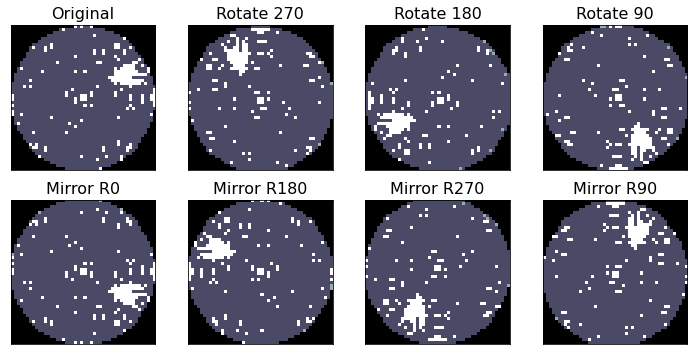

In [21]:
import cv2 as cv 
#=============
def DeOnehotX(gen_x):
    x = np.zeros((len(gen_x),waferSizeX , waferSizeY))
    for w in range(len(gen_x)):
        for i in range(waferSizeX):
            x[w, i]=gen_x[w][i].argmax(1) 
    return x
def add_gooddie(gen_x):  
    gen_x=gen_x.astype('int')
    for w in range(len(gen_x)):
        for i in range(waferSizeX):
            for j in range(waferSizeY):
                gen_x[w][i][j]=gen_x[w][i][j]|goodWafer[i][j]
    return gen_x
def rotate_img(img,angle):
    height = img.shape[0] # 定義圖片的高度
    width = img.shape[1] # 定義圖片的寬度
    center = (int(waferSizeX/2), int(waferSizeY/2)) # 定義圖片的中心
    scale = 1.0 # 指定縮放比例
    # 旋轉
    trans = cv.getRotationMatrix2D(center, angle, scale)
    image = cv.warpAffine(img, trans, (width, height))
    image=np.ceil(image)
    return image
def flip_img(img,flip):
    image=cv.flip(img,flip)
    image=np.ceil(image)
    return image
def cv2_batchgena(count,gx,gy):
    batch_count=0
    x_result = np.zeros((1, waferSizeX, waferSizeY, 3))
    y_result = np.zeros((1,))
    
    for i in range (int(count//7)):
    #generate 11 pics a time
    #1.Mirrow Left 2.Mirrow Up 3,Rotate90 4.Mirrow Left
        a1=rotate_img(gx[i],90) #rotate90
        a2=rotate_img(gx[i],180) #rotate90
        a3=rotate_img(gx[i],270) #rotate90
        a4=flip_img(gx[i],0) #flip left
        a5=flip_img(gx[i],1) #flip up
        a6=flip_img(a1,0)
        a7=flip_img(a1,1)
        x_result = np.concatenate((x_result, a1.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
        x_result = np.concatenate((x_result, a2.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
        x_result = np.concatenate((x_result, a3.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
        x_result = np.concatenate((x_result, a4.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
        x_result = np.concatenate((x_result, a5.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
        x_result = np.concatenate((x_result, a6.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
        x_result = np.concatenate((x_result, a7.reshape(-1,waferSizeX,waferSizeY,3)), axis=0) 
        y_result = np.concatenate((y_result, gy[i].reshape(-1,)), axis=0)
    return x_result[1:],y_result[1:] 

x,y=loadfile('cv2_onehot_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
xa=x[:1]
ya=y[:1]
nx,ny=cv2_batchgena(7,xa,ya)

xa=x[:1]
#=============
def DeOnehotX(gen_x):
    x = np.zeros((len(gen_x),waferSizeX , waferSizeY))
    for w in range(len(gen_x)):
        for i in range(waferSizeX):
            x[w, i]=gen_x[w][i].argmax(1) 
    return x

xa=DeOnehotX(xa)
xa=add_gooddie(xa)
xa=xa.reshape(waferSizeX,waferSizeY)
nnx=DeOnehotX(nx)
nnx=add_gooddie(nnx)

fig , ax = plt.subplots(nrows = 2, ncols=4, figsize=(10,5))
ax = ax.ravel(order='C')
ax[0].imshow(xa,cmap=plt.cm.bone)
ax[0].set_title('Original',fontsize=16)
ax[0].set_xticks([])
ax[0].set_yticks([])
rlist=['Rotate 270','Rotate 180','Rotate 90','Mirror R0','Mirror R180','Mirror R270','Mirror R90']
for i in range(0,7):
    ax[i+1].imshow(nnx[i],cmap=plt.cm.bone)
    ax[i+1].set_title(rlist[i],fontsize=16)
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])  
    
plt.tight_layout()
plt.show()

# Split train / test for each fail, shafful the data

In [22]:
def split_train_test_validate(x,y):
    print('fault  train  test validation')
    print('===============================')
    for i in range (0,len(fault_mapping)-1):
        loc_y=np.where(y==i)[0]
        gen_x = np.zeros((1, waferSizeX, waferSizeY))
        for index in range (len(loc_y)):
            gen_x=np.concatenate((gen_x, x[loc_y[index]].reshape(-1,waferSizeX, waferSizeY)))
        gen_x=gen_x[1:]  
        gen_y=np.full(len(loc_y),i)
        x_tra, x_tesa, y_tra, y_tesa = train_test_split(gen_x, gen_y, test_size=0.3, random_state=2022)  #70% train , 10% valid, 20% test
        x_tes,x_val,y_tes,y_val = train_test_split(x_tesa, y_tesa, test_size=0.333, random_state=2022)
        if i ==0:
            x_train=x_tra
            x_test=x_tes
            x_validate=x_val
            y_train=y_tra
            y_test=y_tes
            y_validate=y_val
        else:
            x_train=np.concatenate((x_train, x_tra), axis=0)
            x_test=np.concatenate((x_test, x_tes), axis=0)
            x_validate=np.concatenate((x_validate, x_val), axis=0)
            y_train=np.concatenate((y_train, y_tra), axis=0)
            y_test=np.concatenate((y_test, y_tes), axis=0)
            y_validate=np.concatenate((y_validate, y_val), axis=0)
        print('%s :%s  %s %s'%(fault_mapping[i],len(y_tra),len(y_tes),len(y_val)))
    print('Total :%s  %s %s'%(len(y_train),len(y_test),len(y_validate)))
    return x_train,y_train,x_test,y_test,x_validate,y_validate

def shuffle_data(x,y):
    import random
    index = [i for i in range(len(y))] 
    random.shuffle(index)
    x = x[index]
    y = y[index]
    return x,y

x,y=loadfile('cv2_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
#x=x[:1000]
#y=y[:1000]
x_train,y_train,x_test,y_test,x_validate,y_validate=split_train_test_validate(x,y)
x_train,y_train=shuffle_data(x_train,y_train)
x_test,y_test=shuffle_data(x_test,y_test)
x_validate,y_validate=shuffle_data(x_validate,y_validate)
savefile('split_train%s_%s'%(waferSizeX,waferSizeY),x_train,y_train)
savefile('split_test%s_%s'%(waferSizeX,waferSizeY),x_test,y_test)
savefile('split_validate%s_%s'%(waferSizeX,waferSizeY),x_validate,y_validate)
savefile('split_train_onehot%s_%s'%(waferSizeX,waferSizeY),OnehotX(x_train),to_categorical(y_train))
savefile('split_test_onehot%s_%s'%(waferSizeX,waferSizeY),OnehotX(x_test),to_categorical(y_test))
savefile('split_validate_onehot%s_%s'%(waferSizeX,waferSizeY),OnehotX(x_validate),to_categorical(y_validate))
print('Save_Completed')

fault  train  test validation
Center :3499  1000 500
Donut :2542  727 363
Edge-Loc :3497  999 500
Edge-Ring :3495  999 500
Loc :3495  999 500
Random :3500  1000 500
Scratch :3496  999 500
Near-full :812  232 116
Total :24336  6955 3479
Save_Completed


In [23]:
#For verification
#x,_=loadfile('split_train%s_%s'%(waferSizeX,waferSizeY))
#printx(x[0])
#x,_=loadfile('split_train_onehot%s_%s'%(waferSizeX,waferSizeY))
#printOnehotx(x[0])

# 分群 (UNSUPERVISED LEARNING)
# Density Based Clustering (DBSCAN)
#https://ithelp.ithome.com.tw/articles/10193760
#https://ithelp.ithome.com.tw/articles/10194172
#https://www.cnblogs.com/pinard/p/6217852.html

![image.png](attachment:aa14da74-cfe2-4046-80ee-8f6d46c2fc06.png)

In [24]:
def dbscan(x):
    org_x=np.copy(x)
    new_x=np.ones((1,waferSizeX,waferSizeY))
    #org_x=org_x[:3000]
    #y=y[:3000]
    percent=0
    for i in range (len(org_x)):
        if y[i]==4 or y[i]==6: #Loc
            max_near_dots=10
            min_near_dots=3
            threashold_dots=100
        else:
            max_near_dots=4
            min_near_dots=1
            threashold_dots=100
        temp=dbscan_denoize(org_x[i],True,max_near_dots,min_near_dots,threashold_dots) #dbscan_denoizea(img,fill_one,max_near_dots,min_near_dots,threashold_dots)
        temp=temp.reshape(-1,waferSizeX,waferSizeY)
        new_x=np.concatenate((new_x,temp),axis=0)
        if ((i*100)/(len(org_x))) > percent:
            percent+=1
            print(percent,end=' ')
    new_x=new_x[1:] 
    print()
    return new_x
    
if DBSCAN_ENABLE==True:  
    x,y=loadfile('split_train%s_%s'%(waferSizeX,waferSizeY))
    new_x=dbscan(x)
    savefile('dbscan_train%s_%s'%(waferSizeX,waferSizeY),new_x,y)
    savefile('dbscan_train_onehot%s_%s'%(waferSizeX,waferSizeY),OnehotX(new_x),to_categorical(y))
    x,y=loadfile('split_test%s_%s'%(waferSizeX,waferSizeY))
    new_x=dbscan(x)
    savefile('dbscan_test%s_%s'%(waferSizeX,waferSizeY),new_x,y)
    savefile('dbscan_test_onehot%s_%s'%(waferSizeX,waferSizeY),OnehotX(new_x),to_categorical(y))
    x,y=loadfile('split_validate%s_%s'%(waferSizeX,waferSizeY))
    new_x=dbscan(x)
    savefile('dbscan_validate%s_%s'%(waferSizeX,waferSizeY),new_x,y)
    savefile('dbscan_validate_onehot%s_%s'%(waferSizeX,waferSizeY),OnehotX(new_x),to_categorical(y))
    print('save_completed')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
save_completed


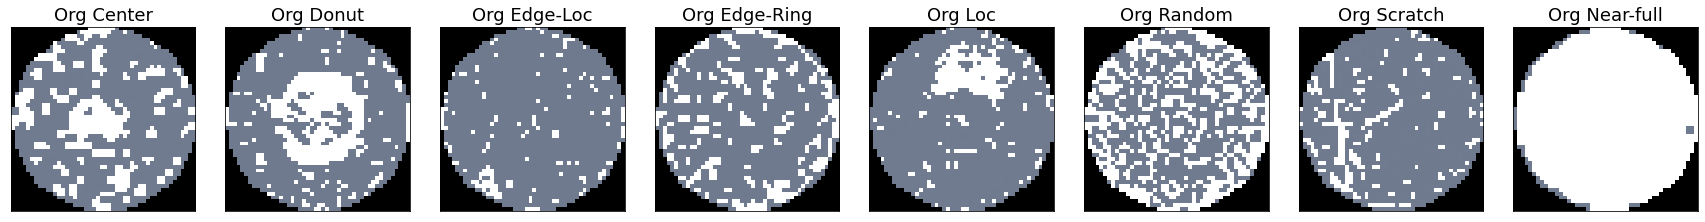

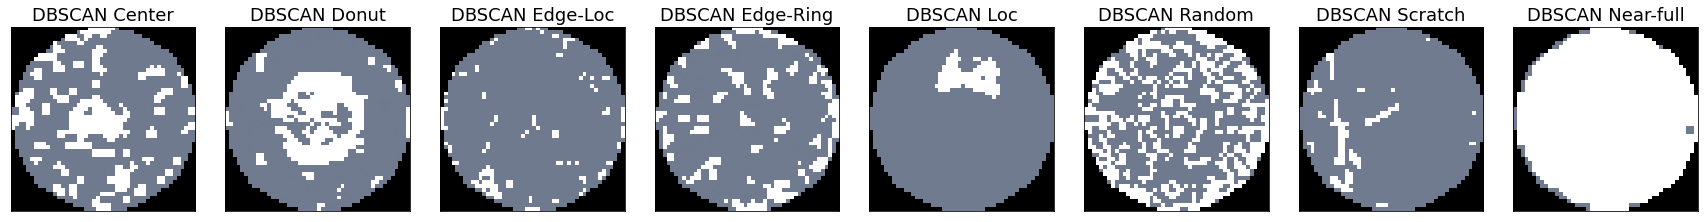

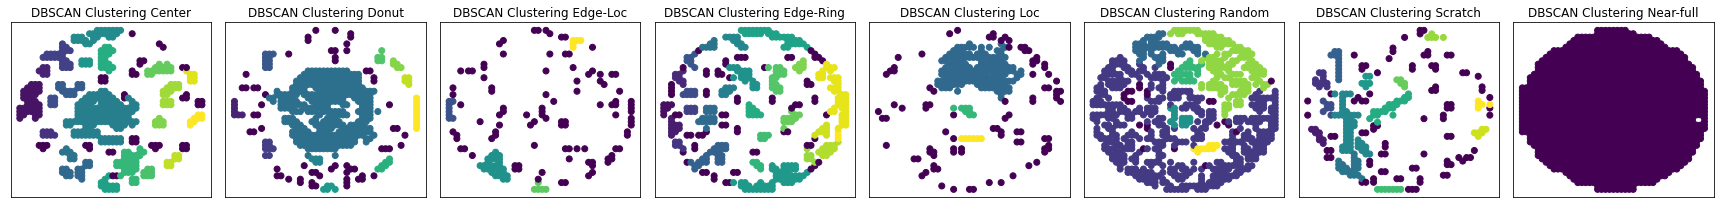

In [25]:
from sklearn.cluster import DBSCAN
from scipy import ndimage
def dbscan_transfer(data):
    coord=np.array([[0,0]])
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j]<2:
                data[i][j]=0
            else:
                a=np.array([[i,j]])
                coord=np.concatenate([coord,a])
    coord=coord[1:]
    result=DBSCAN(eps=2,min_samples=5).fit(coord)
    return result,coord

def dbscan_show(x,stype):
    fig,ax=plt.subplots(1,8,figsize=(24,3))
    pic=0
    for f in range (0,8):
        for i,j in enumerate(y):
            if f==j:
                if stype=='dbscan_clustering':
                    result,coord=dbscan_transfer(x[i].reshape(waferSizeX,waferSizeY))
                    ax[pic].scatter(coord[:,0],coord[:,1],c=result.labels_)
                    ax[pic].set_title('DBSCAN Clustering %s'%fault_mapping[f])
                elif stype=='dbscan':
                    ax[pic].imshow(ndimage.rotate(x[i], 90),cmap=plt.cm.bone)
                    ax[pic].set_title('DBSCAN %s'%fault_mapping[f],fontsize=18)
                elif stype=='org':
                    ax[pic].imshow(ndimage.rotate(x[i], 90),cmap=plt.cm.bone)
                    ax[pic].set_title('Org %s'%fault_mapping[f],fontsize=18)
                ax[pic].set_xticks([])
                ax[pic].set_yticks([])
                pic+=1
                break                    
                    
    fig.tight_layout()
    fig.facecolor=('white')
    plt.show    
    
x,y=loadfile('split_train%s_%s'%(waferSizeX,waferSizeY))
dbscan_show(x,stype='org')
x1,y1=loadfile('dbscan_train%s_%s'%(waferSizeX,waferSizeY))
dbscan_show(x1,stype='dbscan')
dbscan_show(x,stype='dbscan_clustering')

In [26]:
#x,y=loadfile('split_train%s_%s'%(waferSizeX,waferSizeY))
#'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'None':8
#show100map(x,y,fault_mapping[4],0)

#x,y=loadfile('dbscan_train%s_%s'%(waferSizeX,waferSizeY))
#'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'None':8
#show100map(x,y,fault_mapping[4],0)

In [27]:
if REMOVE_BLANK==True:
    #drop wafer if 98% of dots are blank in wafer
    drop_value=0.98
    new_x,new_y=drop_blank('cv2_fail_pattern',drop_value,waferamount)
    new_x=OnehotX(new_x)
    new_y=to_categorical(new_y)
    savefile('cv2_fail_pattern%s_%s'%(waferSizeX,waferSizeY),new_x,new_y)
    print('x shape:%s, y shape:%s'%(str(new_x.shape),str(new_y.shape)))

## 資料增強 (方法二:Convolutional Autoencoder)
As solving class imbalanced problem, we need for data augmentation. <br>
The wafer data is image data. so we use convolutional autoencoder.
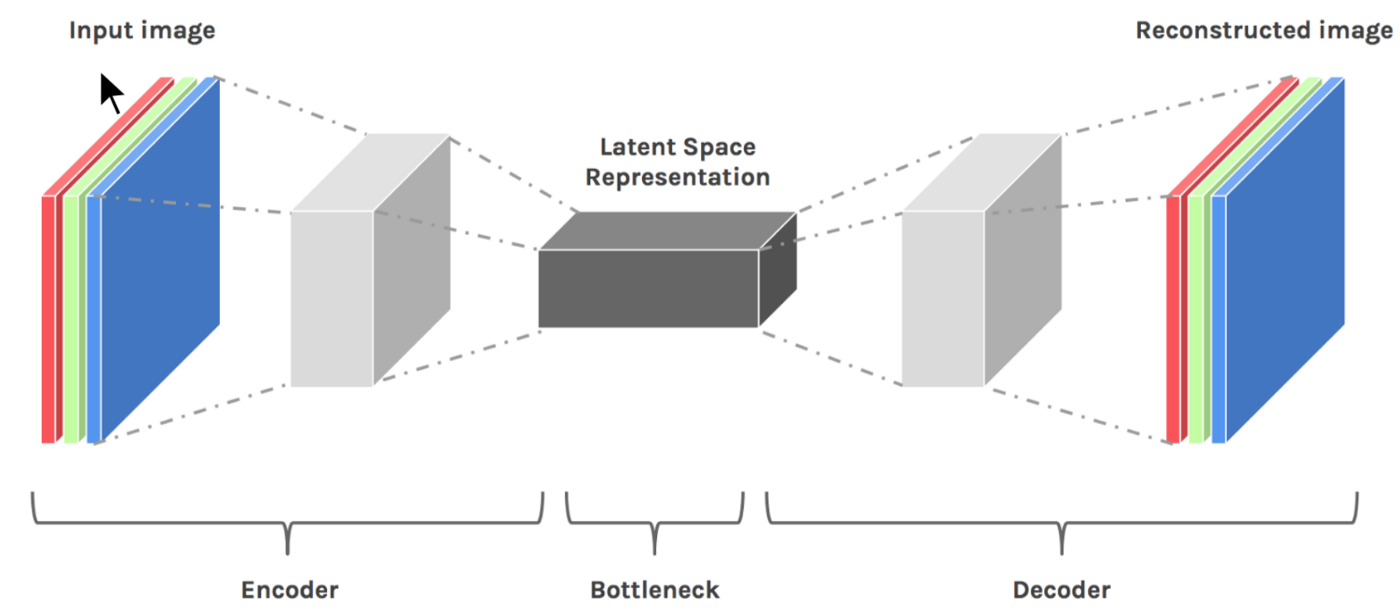
https://medium.com/ai-academy-taiwan/what-are-autoencoders-175b474d74d1
https://blog.keras.io/building-autoencoders-in-keras.html

In [28]:
# parameter
#waferSizeX=26
#waferSizeY=waferSizeX
#korea_x,y=loadfile('korea26_26')
#for i in range(8):
#    a=np.where(y==fault_mapping[i])[0]
#    print(fault_mapping[i],len(a))
#korea_x.shape    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 12, 12, 8)        584 

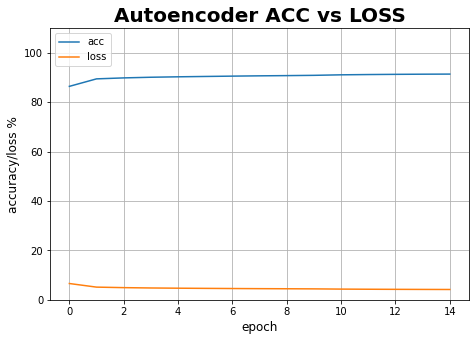

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
Total params: 808
Trainable params: 808
Non-trainable param

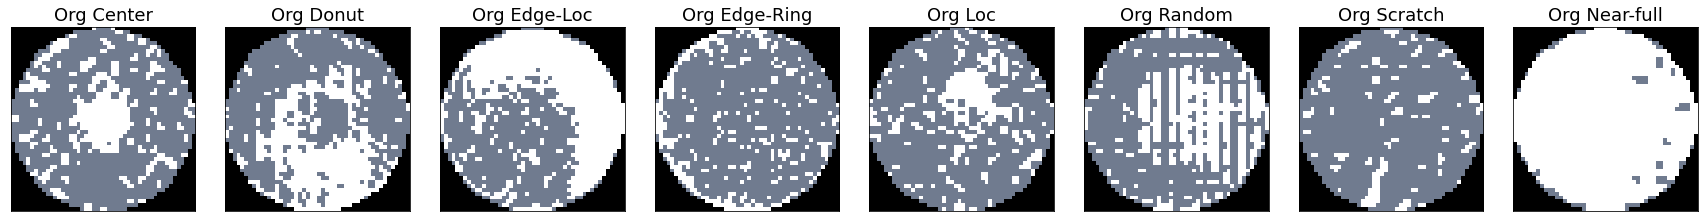

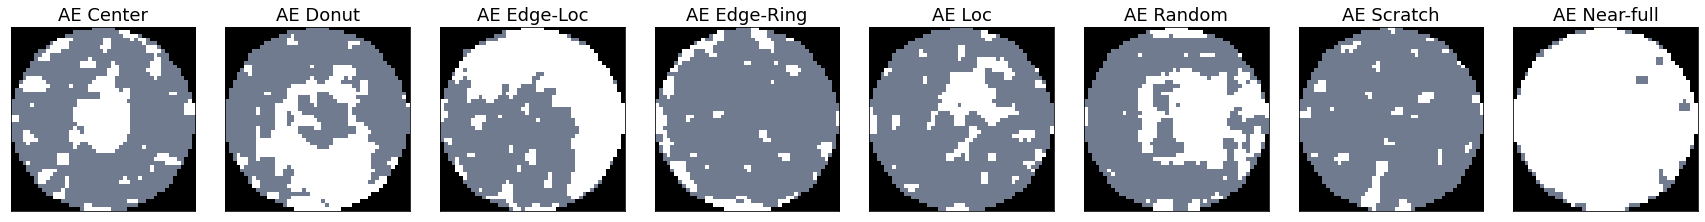

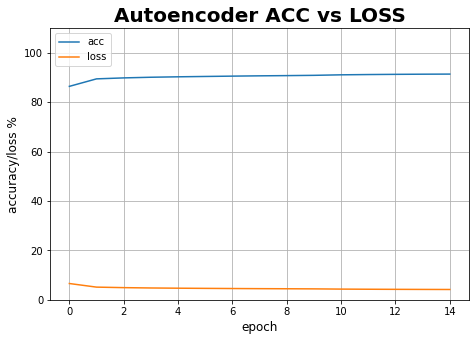

In [48]:
def acc_plotA(mhistory):
    acc_list=[]
    loss_list=[]
    for i in mhistory.history['acc']:
        acc_list.append(i*100)
    for i in mhistory.history['loss']:
        loss_list.append(i*100)
        
    fig, (ax1) = plt.subplots(1, 1, figsize=(7.5,5))
    #fig.suptitle('A tale of 2 subplots')
    ax1.plot(acc_list)
    ax1.plot(loss_list)
    ax1.set_title('Autoencoder ACC vs LOSS',fontweight="bold", size=20)
    ax1.set_ylabel('accuracy/loss %',fontsize=12)
    ax1.set_xlabel('epoch',fontsize=12)
    ax1.legend(['acc', 'loss'], loc='upper left')
    ax1.set_ylim([0,110])
    ax1.autoscalex_on=0
#    ax1.set_yticks(list(range(0,110,10)))
#    ax1.set_xticks(list(range(0,len(mhistory.history['acc']),1)))
#    ax1.set_xticklabels(list(range(1,len(mhistory.history['acc'])+1,1)))
    ax1.grid()   
    fig.savefig('./report_chart/autoencoder_acc_loss.jpg', bbox_inches='tight', dpi=150)
    plt.show()
    return

def autoencoder_show(x,y,stype):
    fig,ax=plt.subplots(1,8,figsize=(24,3))
    pic=0
    for f in range (0,8):
        for i,j in enumerate(y):
            if f==j:
                if stype=='ae':
                    ax[pic].imshow(x[i],cmap=plt.cm.bone)
                    ax[pic].set_title('AE %s'%fault_mapping[f],fontsize=18)
                elif stype=='org':
                    ax[pic].imshow(x[i],cmap=plt.cm.bone)
                    ax[pic].set_title('Org %s'%fault_mapping[f],fontsize=18)
                ax[pic].set_xticks([])
                ax[pic].set_yticks([])
                pic+=1
                break                    
                    
    fig.tight_layout()
    fig.facecolor=('white')
    plt.show 
    return

new_x,y=loadfile('split_train_onehot%s_%s'%(waferSizeX,waferSizeY))
pix=3
kernel=8
epoch=15
batch_size=16
input = Input((waferSizeX,waferSizeY, 3))
encode  = layers.Conv2D(kernel, (pix,pix), padding='same', activation='relu')(input)
encode  = layers.MaxPool2D()(encode) #
encode  = layers.Conv2D(kernel, (pix,pix), padding='same', activation='relu')(encode) #
encoder_layer  = layers.MaxPool2D()(encode)
decode_layer_1 = layers.Conv2DTranspose(kernel, (pix,pix), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
decode_layer_3 = layers.Conv2DTranspose(kernel, (pix,pix), padding='same', activation='relu')
decode_layer_4 = layers.UpSampling2D()

decode = decode_layer_1(encoder_layer)
decode = decode_layer_2(decode)
decode = decode_layer_3(decode) #
decode = decode_layer_4(decode) #
autoencoder_output = layers.Conv2DTranspose(3, (pix,pix), padding='same', activation='sigmoid')

autoencoder_model = models.Model(input, autoencoder_output(decode))
autoencoder_model.compile(optimizer='Adam', loss='mse',metrics=['acc'])
autoencoder_model.summary()
mhistory=autoencoder_model.fit(new_x,new_x, batch_size=batch_size,epochs=epoch,verbose=1)
autoencoder_model.save('./trained_model/%s_Model.h5'%('autoencoder'))

acc_plotA(mhistory)

encoder_model = models.Model(inputs=input, outputs=encoder_layer)
encoder_model.summary()
decoder_input = Input((int(waferSizeX/4),int(waferSizeY/4), kernel))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
decode = decode_layer_3(decode)
decode = decode_layer_4(decode)
decoder_model = models.Model(decoder_input, autoencoder_output(decode))
decoder_model.summary()

#train
encoded_x = encoder_model.predict(new_x)
result_x = decoder_model.predict(encoded_x)
savefile('autoencoder_train_onehot%s_%s'%(waferSizeX,waferSizeY),result_x,y)
gen_x = np.argmax(result_x, axis=3)
gen_y = y.argmax(1)
savefile('autoencoder_train%s_%s'%(waferSizeX,waferSizeY),gen_x,gen_y)
#validate
new_x,y=loadfile('split_validate_onehot%s_%s'%(waferSizeX,waferSizeY))
encoded_x = encoder_model.predict(new_x)
result_x = decoder_model.predict(encoded_x)
savefile('autoencoder_validate_onehot%s_%s'%(waferSizeX,waferSizeY),result_x,y)
gen_x = np.argmax(result_x, axis=3)
gen_y = y.argmax(1)
savefile('autoencoder_validate%s_%s'%(waferSizeX,waferSizeY),gen_x,gen_y)
#Test
new_x,y=loadfile('split_test_onehot%s_%s'%(waferSizeX,waferSizeY))
encoded_x = encoder_model.predict(new_x)
result_x = decoder_model.predict(encoded_x)
savefile('autoencoder_test_onehot%s_%s'%(waferSizeX,waferSizeY),result_x,y)
gen_x = np.argmax(result_x, axis=3)
gen_y = y.argmax(1)
savefile('autoencoder_test%s_%s'%(waferSizeX,waferSizeY),gen_x,gen_y)

del autoencoder_model
del decoder_model
del encoder_model
clear_session()

org_x=np.argmax(new_x, axis=3)
autoencoder_show(org_x,gen_y,'org')
autoencoder_show(gen_x,gen_y,'ae')
acc_plotA(mhistory)
#y.shape

In [ ]:
plt.imshow(org_x[0],cmap=plt.cm.bone)

In [ ]:
plt.imshow(gen_x[0],cmap=plt.cm.bone)

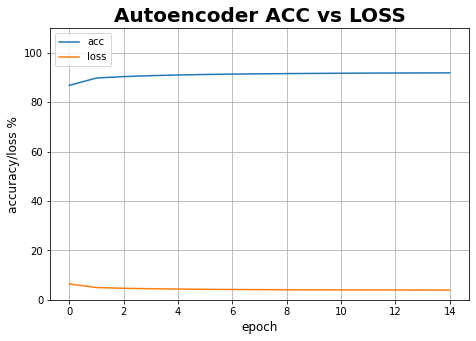

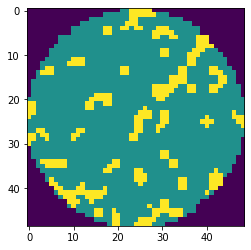

In [10]:
def img_to_coord(img):
    result=[]
    for i in range (waferSizeX):
        for j in range(waferSizeY):

            if img[i][j]==1:
                img[i][j]=0
            if img[i][j]==2:
                temp=[i,j]
                result.append(temp)
    return np.array(result)
def coord_to_img(coord,fill_one):
    if fill_one==True:
        result=np.copy(goodWafer)  #Fill good as 1
    else:
        result=np.zeros((waferSizeX,waferSizeY)) #No fill good as 1
    for i in range(len(coord)):
        result[coord[i][0]][coord[i][1]]=2
    return result

def dbscan_denoizea(img,fill_one,max_near_dots,min_near_dots,threashold_dots):
    #eps:兩個樣本之間的最大距離
    #min_samples:將一個點視為核心點的鄰域中的樣本數
    #fill one : Good die fill 1
    #max_near_dots : 鄰近dot 最大點數
    #min_near_dots : 鄰近dot 最小點數
    #threashold_dots: 整張圖,壞 die 點數
    data=img_to_coord(img)
    for neighbor_dots in range (max_near_dots,min_near_dots,-1):
        db = DBSCAN(eps=2, min_samples=neighbor_dots, metric = 'euclidean',algorithm ='auto')
        db.fit(data)
        #print(len(db.components_))
        if len(db.components_) > threashold_dots:
            break
    return(coord_to_img(db.components_,fill_one))
test=112
temp=dbscan_denoizea(org_x[test],True,4,1,100)
plt.imshow(temp)

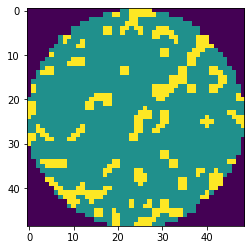

In [8]:
plt.imshow(x[test])

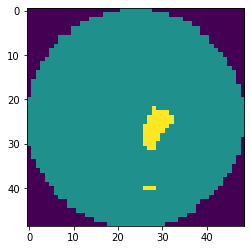

In [51]:
plt.imshow(new_x[62])

In [7]:
if REMOVE_BLANK==True:
    #drop wafer if 98% of dots are blank in wafer
    drop_value=0.98
    new_x,new_y=drop_blank('cv2bd_fail_pattern',drop_value,waferamount)
    new_x=OnehotX(new_x)
    new_y=to_categorical(new_y)
    savefile('cv2bdb_fail_pattern%s_%s'%(waferSizeX,waferSizeY),new_x,new_y)
    print('x shape:%s, y shape:%s'%(str(new_x.shape),str(new_y.shape)))

ORG Wafer Count:21954
 21954/21954 
New Wafer Count:20731
Drop Blank Count: 1223, drop rate: 5.57%
Drop Over 3000 Count: 0, drop rate: 0.00%
0 Center 2952
1 Donut 2995
2 Edge-Loc 2837
3 Edge-Ring 2987
4 Loc 2429
5 Random 2998
6 Scratch 2373
7 Near-full 1160
File Save:cv2bdb_fail_pattern48_48
x shape:(20731, 48, 48, 3), y shape:(20731, 8)


In [9]:
x[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
x,y=loadfile('cv2_fail_pattern%s_%s'%(waferSizeX,waferSizeY))

In [23]:
#fail_plot(x,y,36,2)
print(x.shape)
print(x[0][0][0])
print(y.shape)
print(y[0])

(22140, 48, 48)
0.0
(22140,)
4.0


0-Center : 8
1-Donut : 8
2-Edge-Loc : 8
3-Edge-Ring : 8
4-Loc : 8
5-Random : 8
6-Scratch : 8
7-Near-full : 8
Total: 64
File Save:cv2_onehot_fail_pattern48_48


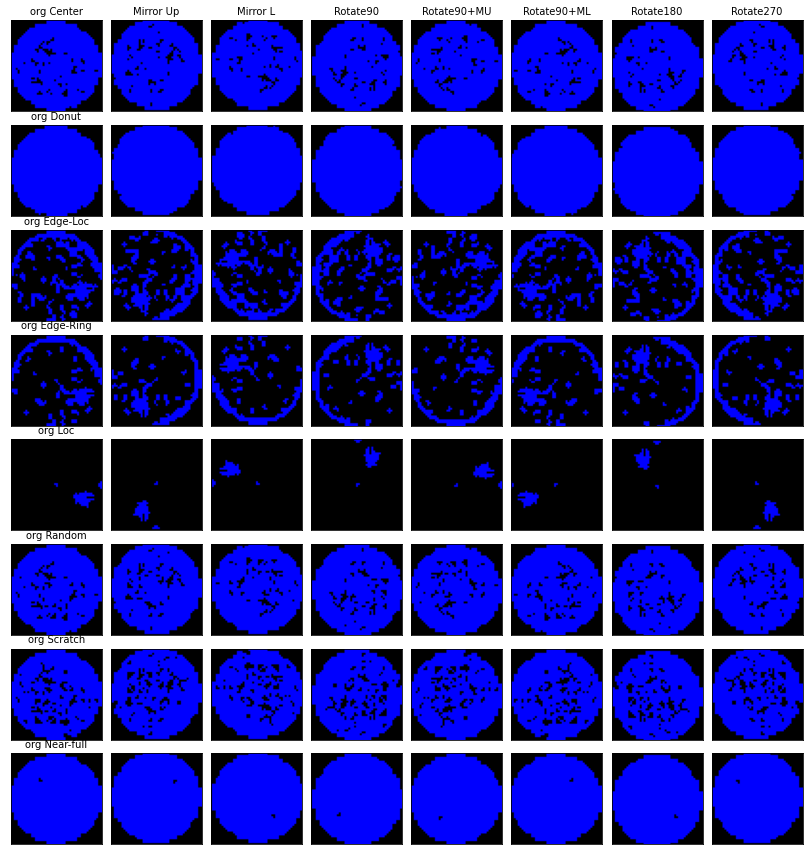

In [24]:
def quick_plot(image,title,row,col,sizex,sizey,font):
    fig, ax = plt.subplots(nrows = row, ncols = col, figsize=(sizex, sizey))
    ax = ax.ravel(order='C')
    for i in range(len(image)):
        ax[i].imshow(image[i],cmap=plt.cm.bone)
        ax[i].set_title(title[i],fontsize=font)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim(0,waferSizeX)
        ax[i].set_ylim(0,waferSizeY)
    plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0.1, 
                    hspace=0.1) 
    #plt.tight_layout()
    plt.show() 

if CV_IMAGE_GENERATOR==True:
    #Show the image rotate type
    #1.Mirror Left 2.Mirror Up 3,Rotate90 4.Mirrow Left
    failType=0
    x,y=loadfile('encoder_x_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
    ax,ay=FindingFailPattern(x,y)
    bx,by=cv2_img_generator(ax,ay,12,True,False,True)
#cv2_img_generator(newx,newy,limit,onehot,rebuildx,save)
    failType=1
    image=np.zeros((1,waferSizeX , waferSizeY , 3))
    for failType in range(8):
        i=8+(7*failType)
        j=i+7
        image=np.concatenate((image,bx[failType].reshape(-1,waferSizeX , waferSizeY , 3)), axis=0)
        image=np.concatenate((image,bx[i:j].reshape(-1,waferSizeX , waferSizeY , 3)), axis=0)
    title=['org %s'%(fault_mapping[0]),'Mirror Up','Mirror L','Rotate90','Rotate90+MU','Rotate90+ML','Rotate180','Rotate270',
           'org %s'%(fault_mapping[1]),'','','','','','','',
           'org %s'%(fault_mapping[2]),'','','','','','','',
           'org %s'%(fault_mapping[3]),'','','','','','','',
           'org %s'%(fault_mapping[4]),'','','','','','','',
           'org %s'%(fault_mapping[5]),'','','','','','','',
           'org %s'%(fault_mapping[6]),'','','','','','','',
           'org %s'%(fault_mapping[7]),'','','','','','','',
          ]
    image=image[1:]
    row=8
    col=8
    font=10
    quick_plot(image,title,row,col,11,11.5,font)
#Ignore 180+ML 180+MU 270+ML 270+MU 

# Keras Image Generator

In [ ]:
x,y=loadfile('encoder_x_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
newx=(x.astype('ubyte')&3)        #pixel
newx=(x.astype('float32'))    #pixel轉成浮點/255 變小於1
newy=y
print('=============Before')
for f in range (8):
    print('%s-%s : %s'%(f,fault_mapping[f],len(y[y==f])))
print('=============After')

=============Before
0-Center : 2000
1-Donut : 454
2-Edge-Loc : 2000
3-Edge-Ring : 2000
4-Loc : 2000
5-Random : 723
6-Scratch : 802
7-Near-full : 145
=============After
(15886, 48, 48, 3)
(15886,)
0-Center : 2000
1-Donut : 1976
2-Edge-Loc : 2000
3-Edge-Ring : 2000
4-Loc : 2000
5-Random : 2022
6-Scratch : 2020
7-Near-full : 1868
11 213 2 1 0 10 9 22 

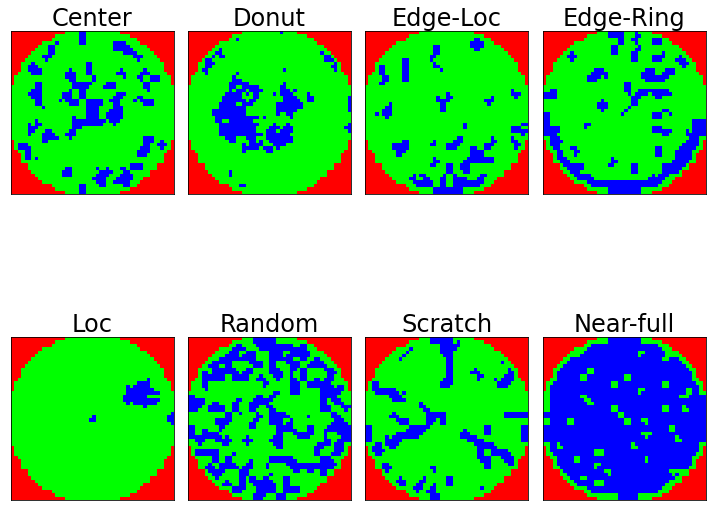

File Saved: gen_fail_pattern48_48


In [22]:
if IMAGE_GENERATOR==True:
    x,y=loadfile('encoder_x_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
    newx=(x.astype('ubyte')&3)        #pixel
    newx=(x.astype('float32'))/255    #pixel轉成浮點/255 變小於1
    newy=y
    print('=============Before')
    for f in range (8):
        print('%s-%s : %s'%(f,fault_mapping[f],len(y[y==f])))
    print('=============After')
    img_generator(newx,newy,2000)

In [10]:
print(latent_vector)

KerasTensor(type_spec=TensorSpec(shape=(None, 24, 24, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [11]:

    
    # start train
#    ae.fit(x,x,batch_size=batch_size,epochs=epoch,verbose=0)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 49, 49, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 64)        3136      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 24, 24, 64)       65600     
 ranspose)                                                       
                                                                 
 up_sampling2d_2 (UpSampling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                           

In [19]:
  
 '''   
    # Make encoder model with part of autoencoder model layers
    encoder = models.Model(input_tensor, latent_vector)
    # Make decoder model with part of autoencoder model layers
    decoder_input = Input((int(waferSizeX/2), int(waferSizeY/2), 64))
    decode = decode_layer_1(decoder_input)
    decode = decode_layer_2(decode)
    decoder = models.Model(decoder_input, output_tensor(decode))
    # Encode original faulty wafer
    encoded_x = encoder.predict(new_x)
    # Add noise to encoded latent faulty wafers vector.
    noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.3, size = (len(encoded_x), int(waferSizeX/2), int(waferSizeY/2), 64))
    # check original faulty wafer data
    #plt.imshow(np.argmax(new_x[3], axis=2))
    # check new noised faulty wafer data
    noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
    # check reconstructed original faulty wafer data
    gen_x = np.argmax(ae.predict(new_x), axis=3)
    # original faulty wafer data
    org_x=np.argmax(new_x,axis=3)
    index=4
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 10))
    ax = ax.ravel(order='C')
    ax[0].imshow(org_x[index],cmap=plt.cm.bone)
    ax[0].set_title('Original',fontsize=12)
    ax[1].imshow(noised_gen_x[index],cmap=plt.cm.bone)
    ax[1].set_title('Noized',fontsize=12)
    ax[2].imshow(gen_x[index],cmap=plt.cm.bone)
    ax[2].set_title('Reconstructed',fontsize=12)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    def gen_data(wafer, label):
        # Encode input wafer
        encoded_x = encoder.predict(wafer)  
        # dummy array for collecting noised wafer
        gen_x = np.zeros((1, int(waferSizeX), int(waferSizeY), 3))
        # Make wafer until total # of wafer to 2000
        for i in range((limit//len(wafer))):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), int(waferSizeX/2), int(waferSizeY/2), 64)) 
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
        # also make label vector with same length
        #numpy.full(shape, fill_value, dtype=None, order='C')[source]
        #返回一个根据指定shape和type,并用fill_value填充的新数组。
        gen_y = np.full((len(gen_x), 1), label)
        #gen_y=gen_y.reshape(1,-1)
        # return date without 1st dummy data.
        return gen_x[1:], gen_y[1:]
    
    # Augmentation for all faulty case.
    new_y=np.copy(y)
    faulty_case=np.unique(y)
    for f in faulty_case : 
        if len(y[y==f]) < limit:
            gen_x, gen_y = gen_data(new_x[np.where(y==f)], f)
            new_x = np.concatenate((new_x, gen_x), axis=0)
            gen_y=gen_y.reshape(1,-1)
            new_y = np.concatenate((new_y, gen_y[0]))

    print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))
    for f in faulty_case :
        print('{} : {}'.format(f, len(new_y[new_y==f])))

    # one-hot-encoding
    new_y = to_categorical(new_y)
    savefile('autoencoder_fail_pattern%s_%s'%(waferSizeX,waferSizeY),new_x,new_y) 
    print('File Save:autoencoder_fail_pattern%s_%s'%(waferSizeX,waferSizeY))
    '''
    return

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 29)

In [17]:
if AUTOENCODER==True:
    x,y=loadfile('split_train%s_%s'%(waferSizeX,waferSizeY))
    autoencoder_modela(x,y)

NameError: name 'autoencoder_modela' is not defined

# GAN
https://ithelp.ithome.com.tw/articles/10208478

In [ ]:
""" Simple implementation of Generative Adversarial Neural Network """
import os
import numpy as np
from IPython.core.debugger import Tracer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
plt.switch_backend('agg')   # allows code to run without a system DISPLAY

class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=28, height=28, channels=1):

        self.width = width
        self.height = height
        self.channels = channels
        self.shape = (self.width, self.height, self.channels)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

    def __generator(self):
        """ Declare generator """
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model

    def __discriminator(self):
        """ Declare discriminator """
        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        return model

    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model

    def train(self, X_train, epochs=20000, batch = 32, save_interval = 100):
        for cnt in range(epochs):
            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape(np.int64(batch/2), self.width, self.height, self.channels)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)

            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))
            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)

    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))
        images = self.G.predict(noise)
        plt.figure(figsize=(10, 10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


if __name__ == '__main__':
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)


    gan = GAN()
    gan.train(X_train)

### Cross validate model
Using sklearn KFold Cross validation, we validate our simple cnn.

In [21]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2022) 
results = cross_val_score(model, x_train, y_train, cv=kfold)

Epoch 1/8
Epoch 1/8
Epoch 1/8


In [14]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
Epoch 1/10
Epoch 1/10
Simple CNN Cross validation score : nan


In [ ]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         )

In [ ]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

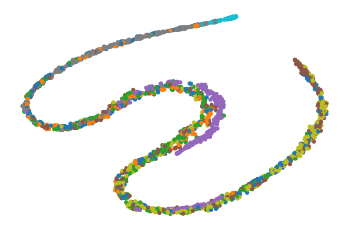

In [32]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

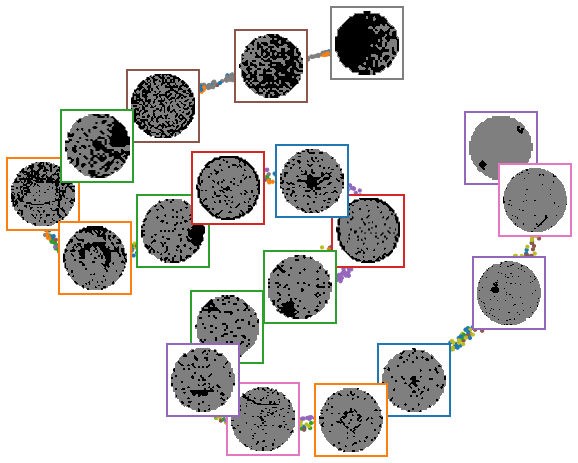

In [35]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
#save_fig("fashion_mnist_visualization_plot")
plt.show()